# Using Multiple Model-Fitting Routines for the Same Model

Sometimes, one may want to fit the same model, albeit using different approaches. For instance, for a 2-armed bandit problem with free parameters $\lbrace \alpha, \beta \rbrace$, where $\alpha$ is the learning rate and $\beta$ is the inverse softmax temperature (a measure of choice randomness), will one obtain better estimates using Expectation-Maximization (EM), Empirical Priors (EP), or Markov Chain Monte-Carlo (MCMC)?

Writing out the code individually for these methods would be tedious, even if there are already wrappers such as `fitr`'s `EM`, `EmpiricalPriors`, and `MCMC` methods. 

For this reason, we have a high level wrapper, `fitrmodel`, in which one can specify both likelihood functions _and_ generative models, allowing direct comparisons of EM, EP, and MCMC. This tutorial shows how this can be done easily with `fitr`.

In [1]:
import numpy as np 

import fitr
from fitr.rlparams import *
from fitr import tasks
from fitr import generative_models as gm 
from fitr import loglik_functions as ll

# Generate some data

We'll use the canonical 2 armed bandit task here.

In [2]:
group = generate_group(params=[LearningRate(), ChoiceRandomness()], nsubjects=50)
taskresults = tasks.bandit(narms=2).simulate(params=group, ntrials=50)

# Create the Models

Since we will be trying to use multiple methods, here, we will need to specify the likelihood function (for non-MCMC methods) as well as the generative model (for MCMC).

For these examples, we'll fit a model with a learning rate and a choice randomness (i.e. inverse softmax temperature) parameter.

In [3]:
banditll = ll.bandit_ll().lr_cr      # EM & EmpiricalPriors methods require likelihood function
banditgm = gm.bandit(model='lr_cr')  # MCMC requires a generative model

model = fitr.fitrmodel(name='My 2-Armed Bandit Model',
                       loglik_func=banditll,                        
                       params=[LearningRate(), ChoiceRandomness()], # Used by EM and Empirical Priors
                       generative_model=banditgm)                   

# Fit the models

Using this single defined model, we can then fit data using multiple methods. Note, however, that the data input formatting will differ depending on which method you are using. For non-MCMC methods, the data dictionary is structured as follows:

For the MCMC method, data dictionary is structured as follows (which might depend on the task you are fitting).

By convention, `fitr` splits steps of tasks into different dictionary entries. So, for example, in the two-step task, where there are two 'States' (one per step), and two 'Actions' (one per step), the data dictionary for MCMC would look as follows:

Now that we know how the data should be formatted for each method, we can fit the models.

In [4]:
emfit = model.fit(data=taskresults.data, method='EM', verbose=False)
epfit = model.fit(data=taskresults.data, method='EmpiricalPriors', verbose=False)
mcfit = model.fit(data=taskresults.data_mcmc, method='MCMC', verbose=False)

     MODEL: My 2-Armed Bandit Model
     METHOD: Expectation-Maximization
     INITIALIZATION: Random Initialization
     N-RESTARTS: 1
     GRID REINITIALIZATION: True
     MAX EM ITERATIONS: 1000
     EARLY STOPPING: True
     CONVERGENCE LIMIT: 0.01
     OPTIMIZATION ALGORITHM: L-BFGS-B
     VERBOSE: False


 MODEL FITTING COMPLETED 

     MODEL: My 2-Armed Bandit Model
     METHOD: Empirical Priors
     ITERATIONS: 1000
     OPTIMIZATION ALGORITHM: L-BFGS-B
     VERBOSE: False



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_663c7b7daa4c656a2ed7f3ba5197de6a NOW.



 MODEL FITTING COMPLETED 

     MODEL: My 2-Armed Bandit Model
     METHOD: Markov Chain Monte-Carlo
     ITERATIONS: 2000
     OPTIMIZATION ALGORITHM: NUTS



## Plot EM Results

### Parameter Histograms

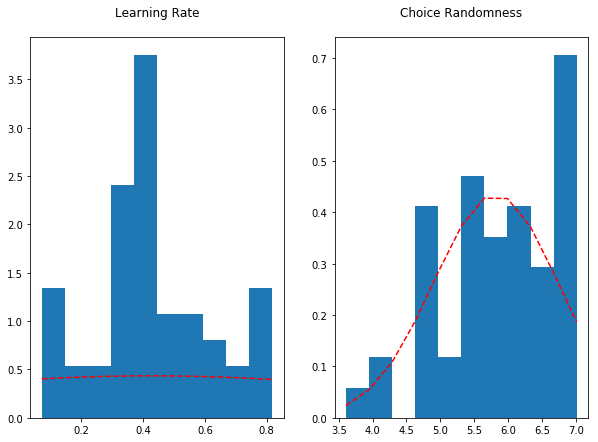

In [5]:
emfit.param_hist()

### Actual-Estimate Scatterplots

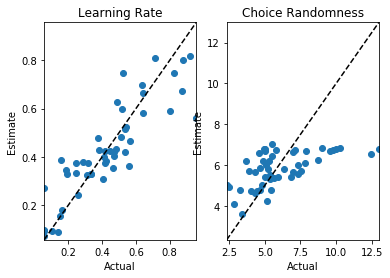

In [6]:
emfit.plot_ae(actual=group)

## Plot Empirical Priors Results

### Parameter Histograms

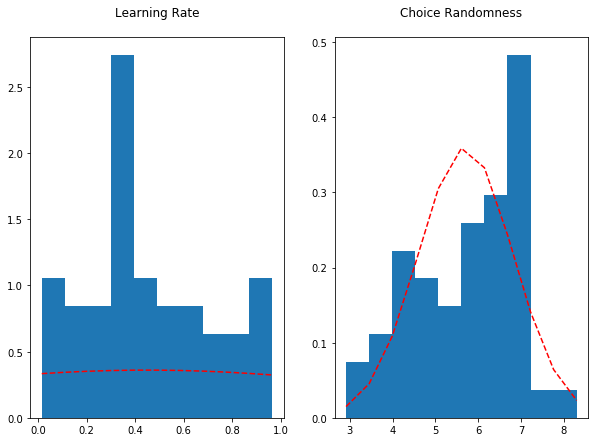

In [7]:
epfit.param_hist()

### Actual-Estimate Scatterplots

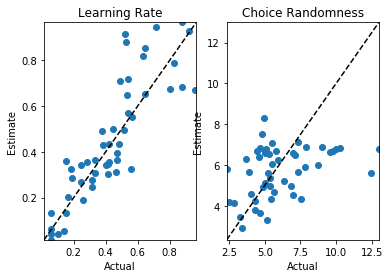

In [8]:
epfit.plot_ae(actual=group)

## Plot MCMC Results

### Parameter Histograms

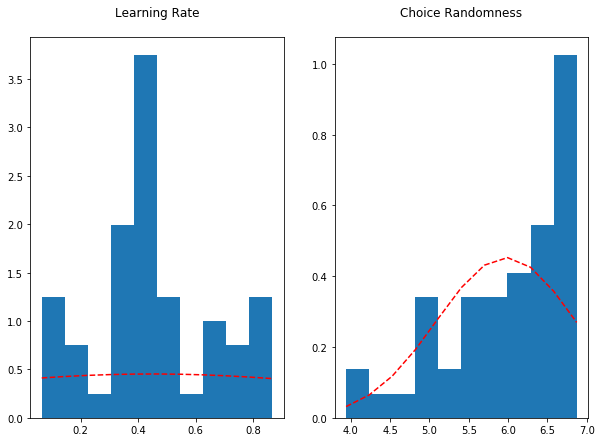

In [9]:
mcfit.param_hist()

### Actual-Estimate Scatterplots

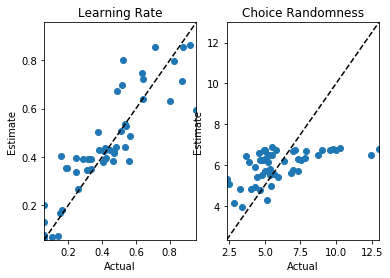

In [10]:
mcfit.plot_ae(actual=group)

### MCMC Trace Plots

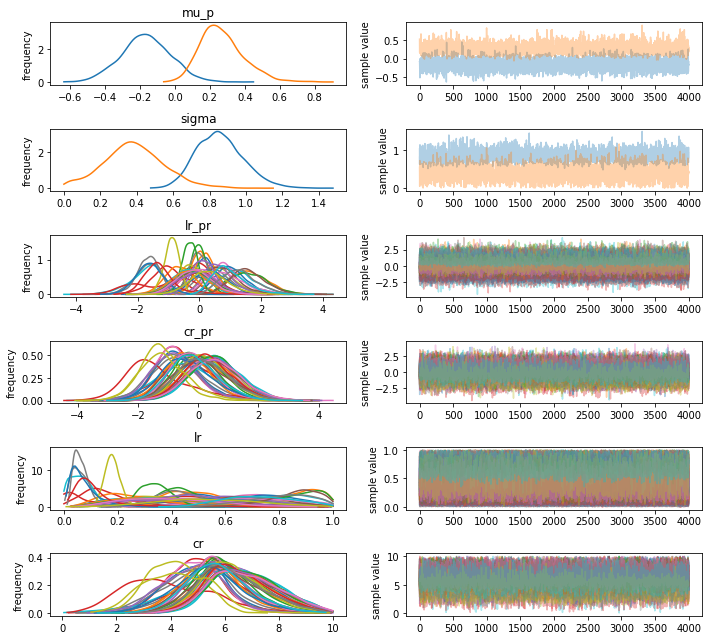

In [11]:
mcfit.trace_plot(figsize=(10, 9))